In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms

import csv
import os

resnet代码

In [2]:
'''ResNet18 in Pytorch.'''

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)

utils使用工具

dataloader

In [3]:
def get_train_dataloader(method='baseline'):
    mean=[x/255.0 for x in [125.3, 123.0, 113.9]]
    std=[x/255.0 for x in [63.0, 62.1, 66.7]]
    # 训练集预处理
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,std=std)
    ])
    if method == 'cutout':
        train_transform.transforms.append(Cutout(args['n_holes'], args['length']))
    cifar100_train_dataset = datasets.CIFAR100(root='./data/Cifar100',
                    train=True,
                    transform=train_transform,
                    download=True)
    cifar100_train_loader = DataLoader(dataset=cifar100_train_dataset,
                        batch_size=args['batch_size'],
                        shuffle=True,
                        pin_memory=True)
    return cifar100_train_loader

def get_test_dataloader():
    mean=[x/255.0 for x in [125.3, 123.0, 113.9]]
    std=[x/255.0 for x in [63.0, 62.1, 66.7]]
    # 测试集预处理
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,std=std)
    ])
    cifar100_test_dataset = datasets.CIFAR100(root='./data/Cifar100',
                    train=False,
                    transform=test_transform,
                    download=True)
    cifar100_test_loader = DataLoader(dataset=cifar100_test_dataset,
                        batch_size=args['batch_size'],
                        shuffle=False,
                        pin_memory=True)
    return cifar100_test_loader

write_csv

In [4]:
class CSVLogger:
    def __init__(self, fieldnames, method ='baseline'):
        filename = './runs/CIFAR100_ResNet18_' + method + '.csv'
        self.csv_file = open(filename, 'a')
        writer = csv.writer(self.csv_file)
        writer.writerow([''])
        self.writer = csv.DictWriter(self.csv_file, fieldnames=fieldnames)
        self.writer.writeheader()
        self.csv_file.flush()

    def writerow(self, row):
        self.writer.writerow(row)
        self.csv_file.flush()

    def close(self):
        self.csv_file.close()

rand_bbox

In [5]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

cutout

In [6]:
class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)
        mask = np.ones((h, w), np.float32)
        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

mixup

In [7]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

训练和测试函数定义

In [8]:
def train_cutout(epoch,model,criterion,optimizer):
    print('\nEpoch: %d' % epoch)
    xentropy_loss_avg = 0.
    correct = 0.
    total = 0.

    progress_bar = tqdm(train_loader)
    for i, (images, labels) in enumerate(progress_bar):
        progress_bar.set_description('Epoch ' + str(epoch))
        
        if args['cuda']:
            images = images.cuda()
            labels = labels.cuda()

        model.zero_grad()
        pred = model(images)

        xentropy_loss = criterion(pred, labels)
        xentropy_loss.backward()
        optimizer.step()

        xentropy_loss_avg += xentropy_loss.item()

        # 计算训练过程中的准确率
        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels.data).sum().item()
        accuracy = correct / total

        # 打印训练过程中的loss和acc
        progress_bar.set_postfix(xentropy='%.3f' % (xentropy_loss_avg / (i + 1)), acc='%.3f' % accuracy)

    return (xentropy_loss_avg / (i + 1)), accuracy

def train_mixup(epoch,model,criterion,optimizer):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader)
    for batch_idx, (inputs, targets) in enumerate(progress_bar):
        progress_bar.set_description('Epoch ' + str(epoch))
        if args['cuda']:
            inputs, targets = inputs.cuda(), targets.cuda()

        # mixup数据处理
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, args['alpha'], args['cuda'])
        inputs, targets_a, targets_b = map(Variable, (inputs, targets_a, targets_b))
        model.zero_grad()
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a.data).cpu().sum().float() + (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(xentropy='%.3f' % (train_loss / (batch_idx + 1)), acc='%.3f' % (correct / total))

    return (train_loss / (batch_idx + 1)), (correct / total).item() / 100

def train_cutmix(epoch,model,criterion,optimizer):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader)
    for batch_idx, (inputs, targets) in enumerate(progress_bar):
        progress_bar.set_description('Epoch ' + str(epoch))
        if args['cuda']:
            inputs, targets = inputs.cuda(), targets.cuda()

        r = np.random.rand(1)
        if args['alpha'] > 0 and r < args['cutmix_prob']: # 使用cutmix的概率
          # 生成mix的样本
            lam = np.random.beta(args['alpha'], args['alpha'])
            if args['cuda']:
                rand_index = torch.randperm(inputs.size()[0]).cuda()
            else:
                rand_index = torch.randperm(inputs.size()[0])
            target_a = targets
            target_b = targets[rand_index]
            bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
            inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
            # 调整lambda以与像素比匹配
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
            # 计算输出
            output = model(inputs)
            loss = mixup_criterion(criterion, output, target_a, target_b, lam)
        else:
            # 计算输出
            output = model(inputs)
            loss = criterion(output, targets)

        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().float()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(xentropy='%.3f' % (train_loss / (batch_idx + 1)),
                acc='%.3f' % (correct / total))

    return (train_loss / (batch_idx + 1)), (correct / total).item()

# 测试函数
def test(model):
    model.eval()
    correct = 0.
    total = 0.
    for images, labels in test_loader:
        if args['cuda']:
            images = images.cuda()
            labels = labels.cuda()

        with torch.no_grad():
            pred = model(images)

        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    test_acc = correct / total
    model.train()
    return test_acc

参数准备

In [9]:
# 定义参数
args = {"dataset": 'cifar100', 
      "model": 'resnet18',  
      "batch_size" : 128,
      "epochs" : 50,  
      "learning_rate": 0.1, 
      "n_holes": 1,
      "length": 16,
      'alpha':0.2,
      "cutmix_prob": 0.1
}
args['cuda'] = torch.cuda.is_available()
cudnn.benchmark = True

torch.manual_seed(0)
if args['cuda']:
    torch.cuda.manual_seed(0)

train_loader = get_train_dataloader()
test_loader = get_test_dataloader()

def param_basedOn_method(method):
    if method == 'cutout':
        train = train_cutout
        writer = SummaryWriter('./runs/train_cutout') # 使用tensorboard进行可视化
    elif method == 'mixup':
        train = train_mixup
        writer = SummaryWriter('./runs/train_mixup')
    elif method == 'cutmix':
        train = train_cutmix
        writer = SummaryWriter('./runs/train_cutmix')
    elif method == 'baseline':
        train = train_cutout
        writer = SummaryWriter('./runs/train_baseline') 
    return train,writer

100%|██████████| 169001437/169001437 [00:59<00:00, 2847115.18it/s] 


Extracting ./data/Cifar100/cifar-100-python.tar.gz to ./data/Cifar100
Files already downloaded and verified


Files already downloaded and verified

Files already downloaded and verified

模型训练和保存函数

In [10]:
def train_save_model(method):
    # 模型
    model = ResNet18(num_classes=100)
    if args['cuda']:
        model = model.cuda()
    # 定义损失函数
    if args['cuda']:
        criterion = nn.CrossEntropyLoss().cuda()
    else:
        criterion = nn.CrossEntropyLoss()
    # 定义优化器
    optimizer = torch.optim.SGD(model.parameters(), lr=args['learning_rate'],
                    momentum=0.9, nesterov=True, weight_decay=5e-4)
    # 定义学习率优化
    scheduler = MultiStepLR(optimizer, milestones=[20, 40], gamma=0.2)
    # 数据储存到csv文件
    try:
        os.makedirs('./runs')
    except:
        pass
    csv_logger = CSVLogger(fieldnames=['epoch', 'train_loss', 'train_acc', 'test_acc'],method=method)
    # 训练模型过程
    train,writer = param_basedOn_method(method)
    for epoch in range(1, args['epochs'] + 1):
        train_loss, train_acc = train(epoch,model,criterion,optimizer)
        test_acc = test(model)
        tqdm.write('test_acc: %.3f' % test_acc)
        scheduler.step()
        row = {'epoch': str(epoch), 'train_loss':str(train_loss), 'train_acc': str(train_acc), 'test_acc': str(test_acc)}
        csv_logger.writerow(row)
        writer.add_scalar('train_loss', train_loss, global_step=epoch)
        writer.add_scalar('train_acc', train_acc, global_step=epoch)
        writer.add_scalar('test_acc', test_acc, global_step=epoch)
    writer.close()
    # 保存模型
    try:
        os.makedirs('./mycheckpoints')
    except:
        pass
    torch.save(model.state_dict(), './mycheckpoints/CIFAR100_ResNet18_' + method + '.pth')
    csv_logger.close()

开始训练：

baseline方法

In [11]:
method = 'baseline'
train_save_model(method)


Epoch: 1


Epoch 1: 100%|██████████| 391/391 [1:27:18<00:00, 13.40s/it, acc=0.092, xentropy=3.943]    


test_acc: 0.158

Epoch: 2


Epoch 2: 100%|██████████| 391/391 [31:54<00:00,  4.90s/it, acc=0.200, xentropy=3.250]  


test_acc: 0.241

Epoch: 3


Epoch 3: 100%|██████████| 391/391 [2:25:50<00:00, 22.38s/it, acc=0.302, xentropy=2.719]    


test_acc: 0.317

Epoch: 4


Epoch 4: 100%|██████████| 391/391 [1:12:49<00:00, 11.18s/it, acc=0.393, xentropy=2.280] 


test_acc: 0.407

Epoch: 5


Epoch 5: 100%|██████████| 391/391 [34:45<00:00,  5.34s/it, acc=0.458, xentropy=1.982]


test_acc: 0.434

Epoch: 6


Epoch 6: 100%|██████████| 391/391 [35:13<00:00,  5.41s/it, acc=0.500, xentropy=1.797]


test_acc: 0.489

Epoch: 7


Epoch 7: 100%|██████████| 391/391 [27:13<00:00,  4.18s/it, acc=0.536, xentropy=1.661]


test_acc: 0.501

Epoch: 8


Epoch 8: 100%|██████████| 391/391 [22:28<00:00,  3.45s/it, acc=0.557, xentropy=1.568]


test_acc: 0.484

Epoch: 9


Epoch 9: 100%|██████████| 391/391 [20:16<00:00,  3.11s/it, acc=0.577, xentropy=1.489]


test_acc: 0.517

Epoch: 10


Epoch 10: 100%|██████████| 391/391 [5:03:06<00:00, 46.51s/it, acc=0.595, xentropy=1.435]      


test_acc: 0.526

Epoch: 11


Epoch 11: 100%|██████████| 391/391 [21:42<00:00,  3.33s/it, acc=0.603, xentropy=1.383]


test_acc: 0.530

Epoch: 12


Epoch 12: 100%|██████████| 391/391 [23:48<00:00,  3.65s/it, acc=0.611, xentropy=1.348]


test_acc: 0.545

Epoch: 13


Epoch 13: 100%|██████████| 391/391 [35:55<00:00,  5.51s/it, acc=0.620, xentropy=1.311] 


test_acc: 0.530

Epoch: 14


Epoch 14: 100%|██████████| 391/391 [55:02<00:00,  8.45s/it, acc=0.630, xentropy=1.278]   


test_acc: 0.507

Epoch: 15


Epoch 15: 100%|██████████| 391/391 [48:31<00:00,  7.45s/it, acc=0.640, xentropy=1.252]    


test_acc: 0.562

Epoch: 16


Epoch 16: 100%|██████████| 391/391 [44:24<00:00,  6.81s/it, acc=0.647, xentropy=1.225]


test_acc: 0.570

Epoch: 17


Epoch 17: 100%|██████████| 391/391 [44:30<00:00,  6.83s/it, acc=0.651, xentropy=1.205]


test_acc: 0.566

Epoch: 18


Epoch 18: 100%|██████████| 391/391 [23:46<00:00,  3.65s/it, acc=0.655, xentropy=1.184]


test_acc: 0.533

Epoch: 19


Epoch 19: 100%|██████████| 391/391 [1:01:10<00:00,  9.39s/it, acc=0.662, xentropy=1.168]  


test_acc: 0.582

Epoch: 20


Epoch 20: 100%|██████████| 391/391 [20:52<00:00,  3.20s/it, acc=0.665, xentropy=1.148]


test_acc: 0.549

Epoch: 21


Epoch 21: 100%|██████████| 391/391 [20:30<00:00,  3.15s/it, acc=0.787, xentropy=0.719]


test_acc: 0.714

Epoch: 22


Epoch 22: 100%|██████████| 391/391 [20:23<00:00,  3.13s/it, acc=0.831, xentropy=0.570]


test_acc: 0.711

Epoch: 23


Epoch 23: 100%|██████████| 391/391 [26:41<00:00,  4.10s/it, acc=0.845, xentropy=0.509]


test_acc: 0.715

Epoch: 24


Epoch 24: 100%|██████████| 391/391 [21:26<00:00,  3.29s/it, acc=0.860, xentropy=0.458]


test_acc: 0.716

Epoch: 25


Epoch 25: 100%|██████████| 391/391 [21:14<00:00,  3.26s/it, acc=0.874, xentropy=0.417]


test_acc: 0.716

Epoch: 26


Epoch 26: 100%|██████████| 391/391 [20:23<00:00,  3.13s/it, acc=0.879, xentropy=0.391]


test_acc: 0.703

Epoch: 27


Epoch 27: 100%|██████████| 391/391 [20:15<00:00,  3.11s/it, acc=0.888, xentropy=0.368]


test_acc: 0.704

Epoch: 28


Epoch 28: 100%|██████████| 391/391 [35:58<00:00,  5.52s/it, acc=0.894, xentropy=0.350]   


test_acc: 0.692

Epoch: 29


Epoch 29: 100%|██████████| 391/391 [1:43:13<00:00, 15.84s/it, acc=0.897, xentropy=0.339]   


test_acc: 0.696

Epoch: 30


Epoch 30: 100%|██████████| 391/391 [2:00:54<00:00, 18.55s/it, acc=0.900, xentropy=0.326]    


test_acc: 0.685

Epoch: 31


Epoch 31: 100%|██████████| 391/391 [21:36<00:00,  3.31s/it, acc=0.900, xentropy=0.328]


test_acc: 0.684

Epoch: 32


Epoch 32: 100%|██████████| 391/391 [20:59<00:00,  3.22s/it, acc=0.899, xentropy=0.325]


test_acc: 0.695

Epoch: 33


Epoch 33: 100%|██████████| 391/391 [22:02<00:00,  3.38s/it, acc=0.904, xentropy=0.313]


test_acc: 0.672

Epoch: 34


Epoch 34: 100%|██████████| 391/391 [56:57<00:00,  8.74s/it, acc=0.904, xentropy=0.319]   


test_acc: 0.682

Epoch: 35


Epoch 35: 100%|██████████| 391/391 [48:53<00:00,  7.50s/it, acc=0.905, xentropy=0.307]   


test_acc: 0.669

Epoch: 36


Epoch 36: 100%|██████████| 391/391 [1:29:48<00:00, 13.78s/it, acc=0.905, xentropy=0.307]   


test_acc: 0.681

Epoch: 37


Epoch 37: 100%|██████████| 391/391 [21:59<00:00,  3.37s/it, acc=0.907, xentropy=0.301]


test_acc: 0.682

Epoch: 38


Epoch 38: 100%|██████████| 391/391 [21:58<00:00,  3.37s/it, acc=0.908, xentropy=0.299]


test_acc: 0.673

Epoch: 39


Epoch 39: 100%|██████████| 391/391 [21:52<00:00,  3.36s/it, acc=0.913, xentropy=0.287]


test_acc: 0.686

Epoch: 40


Epoch 40: 100%|██████████| 391/391 [22:05<00:00,  3.39s/it, acc=0.912, xentropy=0.287]


test_acc: 0.671

Epoch: 41


Epoch 41: 100%|██████████| 391/391 [21:59<00:00,  3.37s/it, acc=0.966, xentropy=0.133]


test_acc: 0.739

Epoch: 42


Epoch 42: 100%|██████████| 391/391 [21:34<00:00,  3.31s/it, acc=0.984, xentropy=0.079]


test_acc: 0.744

Epoch: 43


Epoch 43: 100%|██████████| 391/391 [22:24<00:00,  3.44s/it, acc=0.989, xentropy=0.064]


test_acc: 0.747

Epoch: 44


Epoch 44: 100%|██████████| 391/391 [21:07<00:00,  3.24s/it, acc=0.991, xentropy=0.055]


test_acc: 0.750

Epoch: 45


Epoch 45: 100%|██████████| 391/391 [21:08<00:00,  3.24s/it, acc=0.992, xentropy=0.050]


test_acc: 0.748

Epoch: 46


Epoch 46: 100%|██████████| 391/391 [21:27<00:00,  3.29s/it, acc=0.994, xentropy=0.045]


test_acc: 0.749

Epoch: 47


Epoch 47: 100%|██████████| 391/391 [22:35<00:00,  3.47s/it, acc=0.995, xentropy=0.041]


test_acc: 0.747

Epoch: 48


Epoch 48: 100%|██████████| 391/391 [21:30<00:00,  3.30s/it, acc=0.996, xentropy=0.037]


test_acc: 0.750

Epoch: 49


Epoch 49: 100%|██████████| 391/391 [52:30<00:00,  8.06s/it, acc=0.996, xentropy=0.034]   


test_acc: 0.749

Epoch: 50


Epoch 50: 100%|██████████| 391/391 [3:06:02<00:00, 28.55s/it, acc=0.997, xentropy=0.031]    


test_acc: 0.750


mixup方法

In [12]:
method = 'mixup'
train_save_model(method)


Epoch: 1


Epoch 1: 100%|██████████| 391/391 [46:21<00:00,  7.11s/it, acc=0.082, xentropy=4.074]  


test_acc: 0.141

Epoch: 2


Epoch 2: 100%|██████████| 391/391 [1:10:46<00:00, 10.86s/it, acc=0.168, xentropy=3.547]  


test_acc: 0.223

Epoch: 3


Epoch 3: 100%|██████████| 391/391 [21:30<00:00,  3.30s/it, acc=0.245, xentropy=3.134]


test_acc: 0.291

Epoch: 4


Epoch 4: 100%|██████████| 391/391 [21:53<00:00,  3.36s/it, acc=0.317, xentropy=2.825]


test_acc: 0.368

Epoch: 5


Epoch 5: 100%|██████████| 391/391 [21:33<00:00,  3.31s/it, acc=0.368, xentropy=2.617]


test_acc: 0.418

Epoch: 6


Epoch 6: 100%|██████████| 391/391 [21:01<00:00,  3.23s/it, acc=0.401, xentropy=2.485]


test_acc: 0.450

Epoch: 7


Epoch 7: 100%|██████████| 391/391 [21:06<00:00,  3.24s/it, acc=0.440, xentropy=2.335]


test_acc: 0.474

Epoch: 8


Epoch 8: 100%|██████████| 391/391 [21:47<00:00,  3.35s/it, acc=0.463, xentropy=2.252]


test_acc: 0.450

Epoch: 9


Epoch 9: 100%|██████████| 391/391 [20:55<00:00,  3.21s/it, acc=0.482, xentropy=2.169]


test_acc: 0.502

Epoch: 10


Epoch 10: 100%|██████████| 391/391 [21:33<00:00,  3.31s/it, acc=0.501, xentropy=2.090]


test_acc: 0.494

Epoch: 11


Epoch 11: 100%|██████████| 391/391 [21:24<00:00,  3.28s/it, acc=0.516, xentropy=2.041]


test_acc: 0.529

Epoch: 12


Epoch 12: 100%|██████████| 391/391 [21:27<00:00,  3.29s/it, acc=0.512, xentropy=2.071]


test_acc: 0.550

Epoch: 13


Epoch 13: 100%|██████████| 391/391 [21:03<00:00,  3.23s/it, acc=0.532, xentropy=1.981]


test_acc: 0.569

Epoch: 14


Epoch 14: 100%|██████████| 391/391 [20:59<00:00,  3.22s/it, acc=0.538, xentropy=1.966]


test_acc: 0.536

Epoch: 15


Epoch 15: 100%|██████████| 391/391 [21:16<00:00,  3.27s/it, acc=0.554, xentropy=1.888]


test_acc: 0.546

Epoch: 16


Epoch 16: 100%|██████████| 391/391 [21:06<00:00,  3.24s/it, acc=0.551, xentropy=1.905]


test_acc: 0.559

Epoch: 17


Epoch 17: 100%|██████████| 391/391 [20:26<00:00,  3.14s/it, acc=0.558, xentropy=1.897]


test_acc: 0.535

Epoch: 18


Epoch 18: 100%|██████████| 391/391 [1:53:36<00:00, 17.43s/it, acc=0.557, xentropy=1.896]   


test_acc: 0.550

Epoch: 19


Epoch 19: 100%|██████████| 391/391 [3:13:43<00:00, 29.73s/it, acc=0.561, xentropy=1.884]    


test_acc: 0.561

Epoch: 20


Epoch 20: 100%|██████████| 391/391 [1:11:03<00:00, 10.90s/it, acc=0.569, xentropy=1.862]   


test_acc: 0.577

Epoch: 21


Epoch 21: 100%|██████████| 391/391 [33:53<00:00,  5.20s/it, acc=0.674, xentropy=1.450]


test_acc: 0.708

Epoch: 22


Epoch 22: 100%|██████████| 391/391 [34:58<00:00,  5.37s/it, acc=0.698, xentropy=1.418]


test_acc: 0.713

Epoch: 23


Epoch 23: 100%|██████████| 391/391 [30:47<00:00,  4.73s/it, acc=0.704, xentropy=1.374]


test_acc: 0.708

Epoch: 24


Epoch 24: 100%|██████████| 391/391 [45:25<00:00,  6.97s/it, acc=0.736, xentropy=1.236]   


test_acc: 0.711

Epoch: 25


Epoch 25: 100%|██████████| 391/391 [1:35:47<00:00, 14.70s/it, acc=0.735, xentropy=1.266]    


test_acc: 0.709

Epoch: 26


Epoch 26: 100%|██████████| 391/391 [40:36<00:00,  6.23s/it, acc=0.743, xentropy=1.241]   


test_acc: 0.720

Epoch: 27


Epoch 27: 100%|██████████| 391/391 [21:16<00:00,  3.26s/it, acc=0.738, xentropy=1.239]


test_acc: 0.721

Epoch: 28


Epoch 28: 100%|██████████| 391/391 [20:52<00:00,  3.20s/it, acc=0.757, xentropy=1.133]


test_acc: 0.707

Epoch: 29


Epoch 29: 100%|██████████| 391/391 [21:19<00:00,  3.27s/it, acc=0.742, xentropy=1.213]


test_acc: 0.700

Epoch: 30


Epoch 30: 100%|██████████| 391/391 [21:09<00:00,  3.25s/it, acc=0.746, xentropy=1.214]


test_acc: 0.703

Epoch: 31


Epoch 31: 100%|██████████| 391/391 [21:01<00:00,  3.23s/it, acc=0.751, xentropy=1.177]


test_acc: 0.697

Epoch: 32


Epoch 32: 100%|██████████| 391/391 [21:15<00:00,  3.26s/it, acc=0.758, xentropy=1.156]


test_acc: 0.700

Epoch: 33


Epoch 33: 100%|██████████| 391/391 [24:37<00:00,  3.78s/it, acc=0.751, xentropy=1.190]  


test_acc: 0.701

Epoch: 34


Epoch 34: 100%|██████████| 391/391 [40:08<00:00,  6.16s/it, acc=0.768, xentropy=1.104]   


test_acc: 0.696

Epoch: 35


Epoch 35: 100%|██████████| 391/391 [1:45:30<00:00, 16.19s/it, acc=0.766, xentropy=1.118]    


test_acc: 0.701

Epoch: 36


Epoch 36: 100%|██████████| 391/391 [23:01<00:00,  3.53s/it, acc=0.750, xentropy=1.212]


test_acc: 0.701

Epoch: 37


Epoch 37: 100%|██████████| 391/391 [24:32<00:00,  3.77s/it, acc=0.760, xentropy=1.176]


test_acc: 0.693

Epoch: 38


Epoch 38: 100%|██████████| 391/391 [2:22:44<00:00, 21.90s/it, acc=0.771, xentropy=1.110]    


test_acc: 0.702

Epoch: 39


Epoch 39: 100%|██████████| 391/391 [1:25:29<00:00, 13.12s/it, acc=0.764, xentropy=1.160]    


test_acc: 0.694

Epoch: 40


Epoch 40: 100%|██████████| 391/391 [1:32:00<00:00, 14.12s/it, acc=0.753, xentropy=1.201]    


test_acc: 0.688

Epoch: 41


Epoch 41: 100%|██████████| 391/391 [1:20:14<00:00, 12.31s/it, acc=0.841, xentropy=0.871]  


test_acc: 0.756

Epoch: 42


Epoch 42: 100%|██████████| 391/391 [1:19:19<00:00, 12.17s/it, acc=0.837, xentropy=0.909]   


test_acc: 0.756

Epoch: 43


Epoch 43: 100%|██████████| 391/391 [30:28<00:00,  4.68s/it, acc=0.831, xentropy=0.936]   


test_acc: 0.757

Epoch: 44


Epoch 44: 100%|██████████| 391/391 [25:20<00:00,  3.89s/it, acc=0.849, xentropy=0.881] 


test_acc: 0.759

Epoch: 45


Epoch 45: 100%|██████████| 391/391 [21:32<00:00,  3.30s/it, acc=0.836, xentropy=0.926]


test_acc: 0.756

Epoch: 46


Epoch 46: 100%|██████████| 391/391 [21:20<00:00,  3.28s/it, acc=0.856, xentropy=0.843]


test_acc: 0.756

Epoch: 47


Epoch 47: 100%|██████████| 391/391 [20:57<00:00,  3.22s/it, acc=0.854, xentropy=0.850]


test_acc: 0.754

Epoch: 48


Epoch 48: 100%|██████████| 391/391 [20:48<00:00,  3.19s/it, acc=0.861, xentropy=0.823]


test_acc: 0.752

Epoch: 49


Epoch 49: 100%|██████████| 391/391 [21:11<00:00,  3.25s/it, acc=0.862, xentropy=0.826]


test_acc: 0.758

Epoch: 50


Epoch 50: 100%|██████████| 391/391 [23:19<00:00,  3.58s/it, acc=0.860, xentropy=0.827]


test_acc: 0.756


cutout方法

In [13]:
method = 'cutout'
train_loader = get_train_dataloader(method)
train_save_model(method)

Files already downloaded and verified

Epoch: 1


Epoch 1: 100%|██████████| 391/391 [26:54<00:00,  4.13s/it, acc=0.073, xentropy=4.075]


test_acc: 0.109

Epoch: 2


Epoch 2: 100%|██████████| 391/391 [26:09<00:00,  4.02s/it, acc=0.141, xentropy=3.593]  


test_acc: 0.169

Epoch: 3


Epoch 3: 100%|██████████| 391/391 [1:27:42<00:00, 13.46s/it, acc=0.201, xentropy=3.233]    


test_acc: 0.228

Epoch: 4


Epoch 4: 100%|██████████| 391/391 [1:01:09<00:00,  9.39s/it, acc=0.259, xentropy=2.920]  


test_acc: 0.287

Epoch: 5


Epoch 5: 100%|██████████| 391/391 [23:24<00:00,  3.59s/it, acc=0.310, xentropy=2.679]


test_acc: 0.330

Epoch: 6


Epoch 6: 100%|██████████| 391/391 [23:10<00:00,  3.56s/it, acc=0.354, xentropy=2.467]


test_acc: 0.383

Epoch: 7


Epoch 7: 100%|██████████| 391/391 [25:35<00:00,  3.93s/it, acc=0.389, xentropy=2.308]


test_acc: 0.355

Epoch: 8


Epoch 8: 100%|██████████| 391/391 [24:41<00:00,  3.79s/it, acc=0.418, xentropy=2.166]


test_acc: 0.437

Epoch: 9


Epoch 9: 100%|██████████| 391/391 [23:09<00:00,  3.55s/it, acc=0.445, xentropy=2.055]


test_acc: 0.444

Epoch: 10


Epoch 10: 100%|██████████| 391/391 [21:55<00:00,  3.37s/it, acc=0.469, xentropy=1.966]


test_acc: 0.467

Epoch: 11


Epoch 11: 100%|██████████| 391/391 [24:58<00:00,  3.83s/it, acc=0.483, xentropy=1.888]


test_acc: 0.411

Epoch: 12


Epoch 12: 100%|██████████| 391/391 [23:18<00:00,  3.58s/it, acc=0.503, xentropy=1.819]


test_acc: 0.504

Epoch: 13


Epoch 13: 100%|██████████| 391/391 [40:07<00:00,  6.16s/it, acc=0.512, xentropy=1.768]    


test_acc: 0.493

Epoch: 14


Epoch 14: 100%|██████████| 391/391 [43:29<00:00,  6.68s/it, acc=0.522, xentropy=1.730]    


test_acc: 0.517

Epoch: 15


Epoch 15: 100%|██████████| 391/391 [1:13:22<00:00, 11.26s/it, acc=0.525, xentropy=1.705]  


test_acc: 0.537

Epoch: 16


Epoch 16: 100%|██████████| 391/391 [43:32<00:00,  6.68s/it, acc=0.539, xentropy=1.663]    


test_acc: 0.514

Epoch: 17


Epoch 17: 100%|██████████| 391/391 [43:54<00:00,  6.74s/it, acc=0.545, xentropy=1.635]   


test_acc: 0.535

Epoch: 18


Epoch 18: 100%|██████████| 391/391 [26:00<00:00,  3.99s/it, acc=0.551, xentropy=1.620]


test_acc: 0.497

Epoch: 19


Epoch 19: 100%|██████████| 391/391 [27:01<00:00,  4.15s/it, acc=0.554, xentropy=1.596]


test_acc: 0.552

Epoch: 20


Epoch 20: 100%|██████████| 391/391 [26:17<00:00,  4.04s/it, acc=0.559, xentropy=1.583]


test_acc: 0.521

Epoch: 21


Epoch 21: 100%|██████████| 391/391 [23:16<00:00,  3.57s/it, acc=0.667, xentropy=1.160]


test_acc: 0.679

Epoch: 22


Epoch 22: 100%|██████████| 391/391 [25:36<00:00,  3.93s/it, acc=0.700, xentropy=1.030]


test_acc: 0.691

Epoch: 23


Epoch 23: 100%|██████████| 391/391 [49:46<00:00,  7.64s/it, acc=0.715, xentropy=0.977]   


test_acc: 0.694

Epoch: 24


Epoch 24: 100%|██████████| 391/391 [22:23<00:00,  3.44s/it, acc=0.725, xentropy=0.939]


test_acc: 0.696

Epoch: 25


Epoch 25: 100%|██████████| 391/391 [21:59<00:00,  3.38s/it, acc=0.734, xentropy=0.905]


test_acc: 0.692

Epoch: 26


Epoch 26: 100%|██████████| 391/391 [21:42<00:00,  3.33s/it, acc=0.738, xentropy=0.883]


test_acc: 0.680

Epoch: 27


Epoch 27: 100%|██████████| 391/391 [22:33<00:00,  3.46s/it, acc=0.745, xentropy=0.862]


test_acc: 0.685

Epoch: 28


Epoch 28: 100%|██████████| 391/391 [22:27<00:00,  3.45s/it, acc=0.750, xentropy=0.846]


test_acc: 0.684

Epoch: 29


Epoch 29: 100%|██████████| 391/391 [22:53<00:00,  3.51s/it, acc=0.748, xentropy=0.840]


test_acc: 0.675

Epoch: 30


Epoch 30: 100%|██████████| 391/391 [23:21<00:00,  3.59s/it, acc=0.755, xentropy=0.824]


test_acc: 0.680

Epoch: 31


Epoch 31: 100%|██████████| 391/391 [22:42<00:00,  3.48s/it, acc=0.758, xentropy=0.817]


test_acc: 0.686

Epoch: 32


Epoch 32: 100%|██████████| 391/391 [24:29<00:00,  3.76s/it, acc=0.760, xentropy=0.813]


test_acc: 0.674

Epoch: 33


Epoch 33: 100%|██████████| 391/391 [22:05<00:00,  3.39s/it, acc=0.761, xentropy=0.804]


test_acc: 0.682

Epoch: 34


Epoch 34: 100%|██████████| 391/391 [28:49<00:00,  4.42s/it, acc=0.765, xentropy=0.791]


test_acc: 0.681

Epoch: 35


Epoch 36:  13%|█▎        | 49/391 [02:34<18:17,  3.21s/it, acc=0.787, xentropy=0.726]]

test_acc: 0.692

Epoch: 36


Epoch 36: 100%|██████████| 391/391 [21:03<00:00,  3.23s/it, acc=0.770, xentropy=0.771]


test_acc: 0.685

Epoch: 37


Epoch 37: 100%|██████████| 391/391 [20:53<00:00,  3.21s/it, acc=0.772, xentropy=0.763]


test_acc: 0.691

Epoch: 38


Epoch 38: 100%|██████████| 391/391 [20:53<00:00,  3.21s/it, acc=0.772, xentropy=0.756]


test_acc: 0.687

Epoch: 39


Epoch 39: 100%|██████████| 391/391 [21:35<00:00,  3.31s/it, acc=0.777, xentropy=0.745]


test_acc: 0.681

Epoch: 40


Epoch 40: 100%|██████████| 391/391 [21:12<00:00,  3.25s/it, acc=0.782, xentropy=0.725]  


test_acc: 0.698

Epoch: 41


Epoch 41: 100%|██████████| 391/391 [20:42<00:00,  3.18s/it, acc=0.858, xentropy=0.496]


test_acc: 0.744

Epoch: 42


Epoch 42: 100%|██████████| 391/391 [20:37<00:00,  3.16s/it, acc=0.880, xentropy=0.418]


test_acc: 0.747

Epoch: 43


Epoch 43: 100%|██████████| 391/391 [21:03<00:00,  3.23s/it, acc=0.892, xentropy=0.379]


test_acc: 0.748

Epoch: 44


Epoch 44: 100%|██████████| 391/391 [21:15<00:00,  3.26s/it, acc=0.899, xentropy=0.354]


test_acc: 0.745

Epoch: 45


Epoch 45: 100%|██████████| 391/391 [21:48<00:00,  3.35s/it, acc=0.905, xentropy=0.336]


test_acc: 0.749

Epoch: 46


Epoch 46: 100%|██████████| 391/391 [1:02:09<00:00,  9.54s/it, acc=0.909, xentropy=0.322]  


test_acc: 0.746

Epoch: 47


Epoch 47: 100%|██████████| 391/391 [48:39<00:00,  7.47s/it, acc=0.914, xentropy=0.306]    


test_acc: 0.747

Epoch: 48


Epoch 48: 100%|██████████| 391/391 [54:14<00:00,  8.32s/it, acc=0.915, xentropy=0.294]    


test_acc: 0.749

Epoch: 49


Epoch 49: 100%|██████████| 391/391 [58:28<00:00,  8.97s/it, acc=0.922, xentropy=0.282]    


test_acc: 0.749

Epoch: 50


Epoch 50: 100%|██████████| 391/391 [54:04<00:00,  8.30s/it, acc=0.921, xentropy=0.274]    


test_acc: 0.746


show pictures

Files already downloaded and verified
获取3张图片
torch.Size([3, 3, 32, 32])


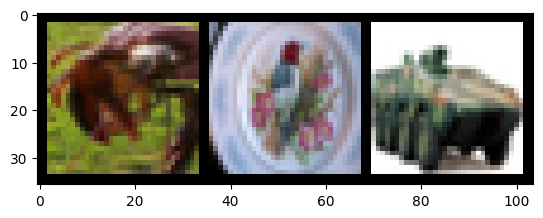

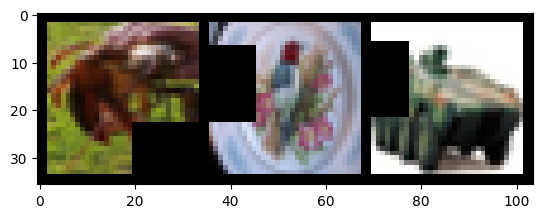

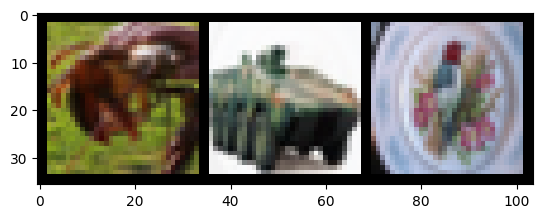

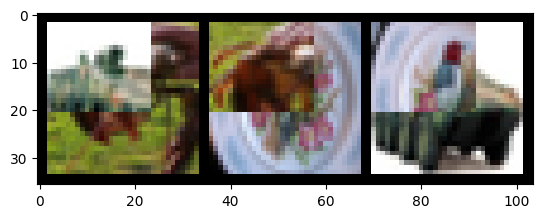

In [14]:
train_transform = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(15), # 数据增强
    transforms.ToTensor(),
    # transforms.Normalize(mean, std)
])
train_dataset = datasets.CIFAR100(root='./data/Cifar100',
                train=True,
                transform=train_transform,
                download=True)
train_loader = DataLoader(dataset=train_dataset,
                    batch_size=args['batch_size'],
                    shuffle=True,
                    pin_memory=True)


print("获取3张图片")
imgs, labels = next(iter(train_loader))
imgs=imgs[0:3]
print(imgs.shape)

# 经过数据增强后的原图
images = make_grid(imgs)
images = images.numpy().transpose(1, 2, 0)
plt.imshow(images)
plt.show()

# 经过cutout处理
cut=Cutout(n_holes=1, length=16)
imgs1=[]
for i in range(3):
    out=cut(imgs[i])
    imgs1.append(out)
images = make_grid(imgs1)
images = images.numpy().transpose(1, 2, 0)
plt.imshow(images)
plt.show()

# 经过mixup处理
lam = np.random.beta(0.2, 0.2)
batch_size = imgs.size()[0]
index = torch.randperm(batch_size)
imgs2 = lam * imgs + (1 - lam) * imgs[index, :]
images = make_grid(imgs2)
images = images.numpy().transpose(1, 2, 0)
plt.imshow(images)
plt.show()

# 经过cutmix处理
r = np.random.rand(1)
lam = np.random.beta(0.2, 0.2)
rand_index = torch.randperm(imgs.size()[0])
bbx1, bby1, bbx2, bby2 = rand_bbox(imgs.size(), lam)
imgs[:, :, bbx1:bbx2, bby1:bby2] = imgs[rand_index, :, bbx1:bbx2, bby1:bby2]
# 调整lambda以与像素比匹配
lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (imgs.size()[-1] * imgs.size()[-2]))
images = make_grid(imgs)
images = images.numpy().transpose(1, 2, 0)
plt.imshow(images)
plt.show()

模型加载和测试

In [15]:
def get_test_acc(method):
    # 模型
    model = ResNet18(num_classes=100)
    if args['cuda']:
        model = model.cuda()
    model.load_state_dict(torch.load('./mycheckpoints/CIFAR100_ResNet18_' + method + '.pth'))
    # 测试
    test_acc = test(model)
    return test_acc

In [17]:
method = 'baseline'
acc = get_test_acc(method)
print(acc)

0.7501


In [18]:
method = 'cutout'
acc = get_test_acc(method)
print(acc)

0.7457


In [19]:
method = 'mixup'
acc = get_test_acc(method)
print(acc)

0.7556
